In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [2]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [3]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/KDD99/6_subsets_smurf/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [4]:
tf.reset_default_graph()

batch_num = 20

hidden_num = 100

step_num = 20

elem_num = sn.shape[1]

iteration = 1000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt"

In [5]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix() for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix() for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix() for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix() for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix() for i in range(t6)]


In [6]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

In [7]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=True)

# Training

iter 1: 0.399369
iter 2: 0.239885
iter 3: 0.184268
iter 4: 0.15819
iter 5: 0.13672
iter 6: 0.122771
iter 7: 0.103626
iter 8: 0.108626
iter 9: 0.0952893
iter 10: 0.0860119
iter 11: 0.0891395
iter 12: 0.0723733
iter 13: 0.067035
iter 14: 0.0603072
iter 15: 0.0553507
iter 16: 0.0470486
iter 17: 0.044108
iter 18: 0.0394956
iter 19: 0.0369362
iter 20: 0.0418431
iter 21: 0.0468768
iter 22: 0.0270281
iter 23: 0.0329936
iter 24: 0.0276549
iter 25: 0.0342826
iter 26: 0.0204546
iter 27: 0.0287298
iter 28: 0.0178652
iter 29: 0.0191946
iter 30: 0.0169057
iter 31: 0.0236177
iter 32: 0.017014
iter 33: 0.017172
iter 34: 0.0158749
iter 35: 0.0161615
iter 36: 0.0195759
iter 37: 0.0230897
iter 38: 0.0115461
iter 39: 0.0135149
iter 40: 0.0126365
iter 41: 0.008485
iter 42: 0.0140988
iter 43: 0.0159363
iter 44: 0.0162823
iter 45: 0.0135879
iter 46: 0.0140141
iter 47: 0.0165593
iter 48: 0.0115928
iter 49: 0.00605818
iter 50: 0.0227547
iter 51: 0.0106183
iter 52: 0.0069533
iter 53: 0.0120528
iter 54: 0.00888

iter 401: 0.00163915
iter 402: 0.000792262
iter 403: 0.00480951
iter 404: 0.00290454
iter 405: 0.00575336
iter 406: 0.0023658
iter 407: 0.00248538
iter 408: 0.00449856
iter 409: 0.00390943
iter 410: 0.00182614
iter 411: 0.00424042
iter 412: 0.00328294
iter 413: 0.00194586
iter 414: 0.00173022
iter 415: 0.0050503
iter 416: 0.00215739
iter 417: 0.00241843
iter 418: 0.00850283
iter 419: 0.00393733
iter 420: 0.00237133
iter 421: 0.00363167
iter 422: 0.0015078
iter 423: 0.00320973
iter 424: 0.0019075
iter 425: 0.00200868
iter 426: 0.00036417
iter 427: 0.00336282
iter 428: 0.00139706
iter 429: 0.00259961
iter 430: 0.00236385
iter 431: 0.00301972
iter 432: 0.00151747
iter 433: 0.00194769
iter 434: 0.00497876
iter 435: 0.00423035
iter 436: 0.00330034
iter 437: 0.00491049
iter 438: 0.00249775
iter 439: 0.00217988
iter 440: 0.00218558
iter 441: 0.00200516
iter 442: 0.000851522
iter 443: 0.00386131
iter 444: 0.00265167
iter 445: 0.00108691
iter 446: 0.00429191
iter 447: 0.00314065
iter 448: 0.002

iter 794: 0.00250634
iter 795: 0.00222079
iter 796: 0.00085657
iter 797: 0.00262223
iter 798: 0.00160682
iter 799: 0.00127266
iter 800: 0.00282568
iter 801: 0.00515462
iter 802: 0.00123773
iter 803: 0.00259015
iter 804: 0.00127856
iter 805: 0.00415439
iter 806: 0.00137294
iter 807: 0.00273034
iter 808: 0.00080864
iter 809: 0.00309428
iter 810: 0.00312251
iter 811: 0.00148978
iter 812: 0.00297024
iter 813: 0.00354668
iter 814: 0.00317853
iter 815: 0.00176697
iter 816: 0.00335463
iter 817: 0.00251018
iter 818: 0.00433777
iter 819: 0.00315205
iter 820: 0.00323324
iter 821: 0.00325341
iter 822: 0.00530737
iter 823: 0.00131448
iter 824: 0.00624522
iter 825: 0.0037219
iter 826: 0.00220656
iter 827: 0.00315833
iter 828: 0.0020206
iter 829: 0.000695245
iter 830: 0.00375838
iter 831: 0.00320518
iter 832: 0.00246795
iter 833: 0.00603566
iter 834: 0.0034559
iter 835: 0.00312622
iter 836: 0.00101266
iter 837: 0.00227559
iter 838: 0.00324272
iter 839: 0.00565733
iter 840: 0.00261081
iter 841: 0.003

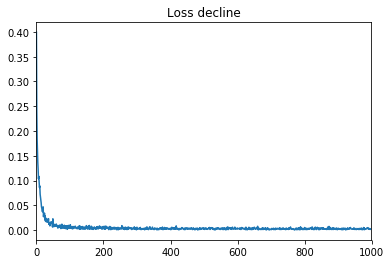

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [9]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    err_vec_list = []
    for _ in range(len(vn1_list)//batch_num):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(vn1_list)-1)
            sub = vn1_list[ind]
            data.append(sub)
        data = np.array(data)
        (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})
        err_vec_list.append(abs(input_ - output_))
    err_vec = np.mean(np.array(err_vec_list),axis=0).reshape(batch_num,-1)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Finished


In [13]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]

threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2

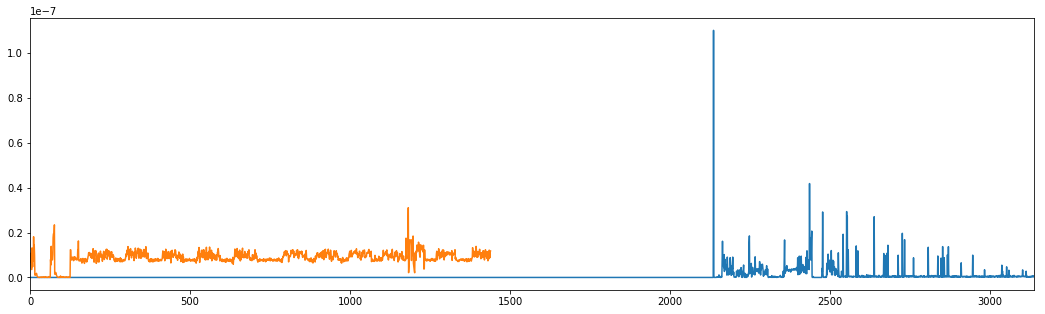

In [12]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

In [18]:
beta = 0.1
tp = np.array(abnormal_score)[abnormal_score>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[normal_score>threshold].size
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.962389819718477

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_kdd99_v1.ckpt
Model restored.
Initialized
Predict result :


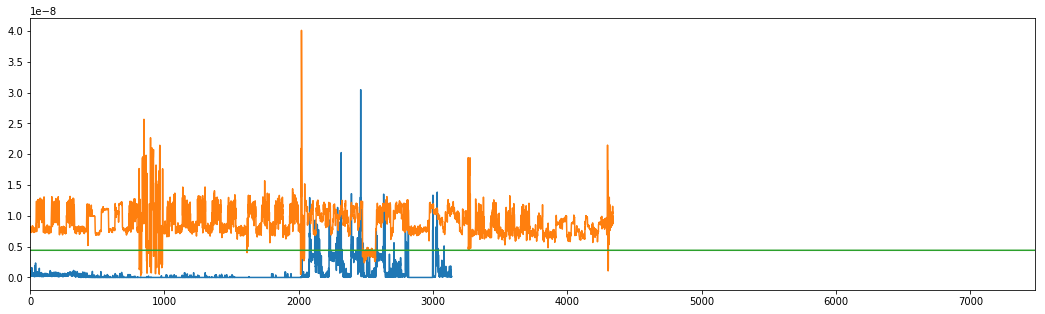

In [15]:
with tf.Session() as sess:
    saver.restore(sess, modlepath)  # decode_without_input=True, iter=5000
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        err_n = err_n.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        err_a = err_a.reshape(batch_num,-1)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Predict result :')

#    print("normal score ",normal_score)
#    print("abnormal score ",abnormal_score)
    pd.Series(normal_score).plot(figsize=(18,5))
    pd.Series(abnormal_score).plot()
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot()

# Evaluation

In [19]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.962389819718477

In [20]:
print(tp,fp,tn,fn,P,R)

4176 164 3057 83 0.9622119815668203 0.9805118572434844
